In [ ]:
import pandas as pd

# 四个表格数据读取
gs_table=pd.read_csv('/home/kesci/input/inv_data6040/01_工商信息.csv')
mp_table=pd.read_csv('/home/kesci/input/inv_data6040/02_主要人员.csv')
tz_table=pd.read_csv('/home/kesci/input/inv_data6040/03_投融资事件.csv')
mt_table=pd.read_csv('/home/kesci/input/inv_data6040/核心团队.csv')

In [ ]:
## 下面是分离出“生物医药”行业的信息，并作出一些初步数据类型转化和清洗

# 读取生物医药行业的工商信息
medical_gs=gs_table[gs_table['产业图谱'].str.contains('生物医药')]

# 将注册资本改为数值、单位/元
def zijin_change(x):
    result= 0
    if  isinstance(x, float) :
        return x
    else:
        if x.find('万元') >=0:
            result = float(x.replace('万元','')) 
        elif x.find('万美元') >=0 :
            result = float(x.replace('万美元',''))  * 7.08
        elif x.find('万日元') >=0 :
            result = float(x.replace('万日元',''))  * 0.0656
        elif x.find('万英镑') >=0 :
            result = float(x.replace('万英镑',''))  * 8.733
        elif x.find('万港元') >=0 :
            result = float(x.replace('万港元',''))  * 0.9142
        elif x.find('万欧元') >=0 :
            result = float(x.replace('万欧元',''))  * 7.6614
        else:
            x = float(x)
        return result
medical_gs.注册资本 = medical_gs.注册资本.apply(lambda x : zijin_change(x)  )

#将日期改为datetime格式并增加为索引
medical_gs.成立时间 = pd.to_datetime(medical_gs.成立时间)
medical_gs.index = pd.DatetimeIndex(medical_gs.成立时间)


## 下面分离出生物医药行业投融资事件信息，并作数据转化
#先对tz_table转时间为datetime类型
tz_table.交易时间 = pd.to_datetime(tz_table.交易时间)

# 将空值写为'暂无'
tz_table['产业图谱']=tz_table['产业图谱'].fillna('暂无')
tz_table['产业图谱'].value_counts()

#将日期改为datetime格式并增加为索引
medical_tz=tz_table[tz_table['产业图谱'].str.contains('生物医药')]
medical_tz.index = pd.DatetimeIndex(medical_tz.交易时间)

In [ ]:
##########################
# 下面是数据预处理和数据挖掘过程
##########################
## 下面是根据分析方向对数据进行数据挖掘过程

# 利用投资信息的企业估值和工商信息的注册资本求投资回报率
em_tb=medical_tz[['标的企业全称','企业估值 (万元)']] # 企业估值
zb_tb=medical_gs[['企业名称','注册资本']]  # 注册资本

# 删除 企业估值、注册资本的空值项
em_tb.reset_index(drop = True)
zb_tb.reset_index(drop = True)
em_tb.columns=['企业名称','企业估值']

# 按照企业名称相同对两列数据合并成新的表
return_tb=pd.merge(em_tb,zb_tb,on=['企业名称','企业名称'],how='inner')

# 求投资回报率并将投资回报率保存在第三列，得到企业投资回报率表
return_tb.dropna(axis=0,inplace=True)
return_tb['return_rate']=return_tb['企业估值']/return_tb['注册资本']
#回报率排名
return_tb.sort_values(by='return_rate', ascending=False).head(1)

# 对投资回报率大于1的企业给label=1,小于1企业给label=0,得到包含label的新表la_tb
lb_tb=return_tb
lb_tb['label']=0
lb_tb['label'][lb_tb['return_rate']>1]=1

# 将这些在lb_tb里的企业（已有label）的工商信息提取出来并合并，得到gs_lb表
label0_qiye=lb_tb[lb_tb['label']==0].企业名称.values
label1_qiye=lb_tb[lb_tb['label']==1].企业名称.values
gs_lb0=medical_gs[medical_gs.企业名称.isin(label0_qiye)]
gs_lb1=medical_gs[medical_gs.企业名称.isin(label1_qiye)]
gs_lb0['label']=0
gs_lb1['label']=1
gs_lb=pd.concat([gs_lb1,gs_lb0])

# 将有label的工商信息表gs_lb保存到work区，csv文件
gs_lb.to_csv('/home/kesci/work/gs_lb.csv')

# 打印出升值企业占比重
rat=gs_lb1.shape[0]/gs_lb.shape[0]
print('----------------\n','升值企业占比中:\n',rat,'\n----------------\n')

# 展示以保存的gs_lb的前两条信息
gs_lb.head(2)  # 最后一行即为label

----------------
 升值企业占比中:
 0.7355371900826446 
----------------

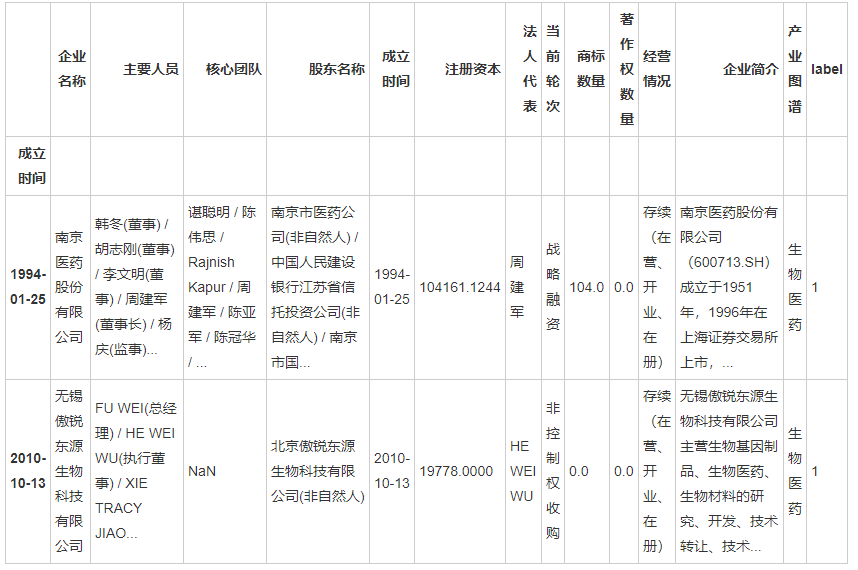

In [ ]:
## 为利用SVM支持向量机对企业进行预测分类，对企业简介进行分词操作
import jieba
import numpy as np
# 将所有企业简介合并到一起
#description = " ".join([str(x) for x in medical_gs.企业简介.values])
medical_gs.企业简介.fillna('暂无',inplace=True)
f=open('/home/kesci/work/stopwords1.txt','r',encoding='gbk')
stopwords=f.read().split('\n')
stopwords += ['股份','有限','有限公司', '公司','暂无','成立','一家','企业','出生','提供','江苏','拥有'] 
f.close()

# 去停用词函数
def cleanline(strline):
    line=jieba.lcut(str(strline))
    cleanline=[x for x in line if x not in stopwords]
    wordsclean = [x for x in cleanline if len(x.strip())>=2 ]
    return wordsclean

# 对所有企业简介进行分词、去停用词
jianjie=[]
for strline in medical_gs.企业简介.values:
    jianjie.append(cleanline(strline))
# 对medical_gs添加分词得到的分词column：'简介清洗分词'
medical_gs['简介清洗分词']=jianjie

# 对label=1、label=0的企业分布进行同样操作
gs_lb1.企业简介.fillna('暂无',inplace=True)
jianjie_lb1=[]
for strline in gs_lb1.企业简介.values:
    jianjie_lb1.append(cleanline(strline))
gs_lb1['简介清洗分词']=jianjie_lb1

gs_lb0.企业简介.fillna('暂无',inplace=True)
jianjie_lb0=[]
for strline in gs_lb0.企业简介.values:
    jianjie_lb0.append(cleanline(strline))
gs_lb0['简介清洗分词']=jianjie_lb0

############## 对这些分词数据进行格式调整，以满足SVM模型的输入格式###########
fenci_lb1=[]
for t in gs_lb1.简介清洗分词.values:
    strline=' '.join(t)
    fenci_lb1.append(strline)

fenci_lb0=[]
for t in gs_lb0.简介清洗分词.values:
    strline=' '.join(t)
    fenci_lb0.append(strline)
    
fenci_lb_12=fenci_lb1+fenci_lb0

lb1=list(gs_lb1.label.values)
lb0=list(gs_lb0.label.values)
lb=lb1+lb0

#总数据
medical_jj_nona=medical_gs[medical_gs['企业简介']!=np.nan]
fenci_all=[]
for t in medical_jj_nona.简介清洗分词.values:
    strline=' '.join(t)
    fenci_all.append(strline)

In [ ]:
# 下面是利用python sklearn库的SVM模型进行学习
from sklearn.feature_extraction.text import CountVectorizer # 计算TF的模块
from sklearn.feature_extraction.text import TfidfTransformer # 计算TF-IDF矩阵的模块
from sklearn.svm import SVC # 支持向量机模块

count_vo=CountVectorizer()  # 初始化这个对象
count_alls=count_vo.fit_transform(fenci_all)  # 构造一个全部文本的TF对象

count_v1=CountVectorizer(vocabulary=count_vo.vocabulary_)
count_train=count_v1.fit_transform(fenci_lb_12) # 求得训练集的TF矩阵

count_v2=CountVectorizer(vocabulary=count_vo.vocabulary_)
test_train=count_v2.fit_transform(fenci_lb_12)  # 求得测试集TF矩阵

count_v3=CountVectorizer(vocabulary=count_vo.vocabulary_)
exam=count_v3.fit_transform(fenci_all)  # 求得测试集TF矩阵

# 以下是根据TF矩阵 求TF-IDF矩阵
tf_idf=TfidfTransformer()
train_data=tf_idf.fit(count_train).transform(count_train)
test_data=tf_idf.fit(test_train).transform(test_train)
exam_data=tf_idf.fit(exam).transform(exam)

# 训练模型
svclf=SVC(gamma=1e-7,C=1e8) # 初始化SVM支持向量机模型
svclf.fit(train_data,lb) # 对训练集进行训练
predict=svclf.predict(test_data) # 对测试集进行预测

num=0
for i in range(len(predict)):
    if predict[i]==lb[i]:
        num+=1
rat=float(num)/len(predict)

# 对所有简介不为空的企业进行预测并得到label，得到的2301个企业工商信息以及相应label保存在medical_jj_nona表中
exam_predict=svclf.predict(exam_data) 
medical_jj_nona['label']=exam_predict
exam_predict=svclf.predict(exam)
rat=sum(exam_predict)/len(exam_predict)
print('预测中的升值企业比：',rat)
# 保存medical_jj_nona表
medical_jj_nona.to_csv('/home/kesci/work/medical_jj_nona.csv')

预测中的升值企业比： 0.7705345501955672

In [ ]:
##########################
# 以上完成数据挖掘过程
##########################
# 下面是对挖掘出的数据进行可视化
import pandas as pd
#所有升值企业简介中的高频词，目的是查看升值企业的总体特点
# 其中对相近的词语进行归类合并，如（医药、药品）
medical1=medical_jj_nona[medical_jj_nona['label']==1]
jianjie_lb1=medical1.简介清洗分词.values
jianjie_all_lb1=[]
for t in jianjie_lb1:
    jianjie_all_lb1+=cleanline(t)
    
#升值企业高频词处理
sz=(pd.Series(jianjie_all_lb1).value_counts()[0:50]/len(jianjie_all_lb1))
sz['研发/技术']=sz['研发']+sz['技术']+sz['科技']
sz['器械/设备']=sz['医疗器械']+sz['设备']
sz['(药物)']=sz['医药']+sz['药业']
sz=sz.drop(['研发','技术','科技','医疗器械','设备','药业','医药'])
sz.sort_values(inplace=True)
sz=sz[30:]
sz.plot(kind='barh',figsize=(10,8),title='升值企业高频词处理后图表')

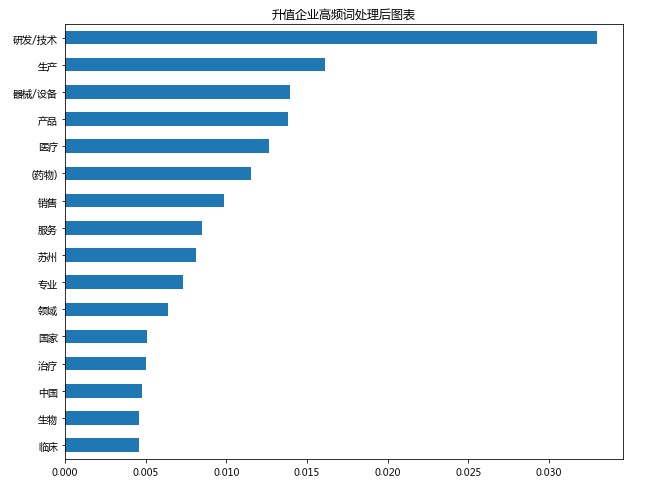

In [ ]:
# 同理绘制出贬值企业的企业简介高频词，与上图对比
medical0=medical_jj_nona[medical_jj_nona['label']==0]
jianjie_lb0=medical0.简介清洗分词.values
jianjie_all_lb0=[]
for t in jianjie_lb0:
    jianjie_all_lb0+=cleanline(t)
#贬值企业高频词处理,相近词语合并
sz=pd.Series(jianjie_all_lb0).value_counts()[0:50]/len(jianjie_all_lb0)
sz['研发/技术']=sz['研发']+sz['技术']+sz['研究']+sz['开发']+sz['生物科技']+sz['科技']
sz['(药物)']=sz['药物']+sz['医药']
sz=sz.drop(['研发','技术','科技','科技','研究','生物科技','药物','医药'])
sz.sort_values(inplace=True)
sz=sz[30:]
sz.plot(kind='barh',figsize=(10,8),title='贬值企业高频词处理后图表')
sz.plot(kind='barh',figsize=(10,8),title='贬值企业高频词处理后图表')

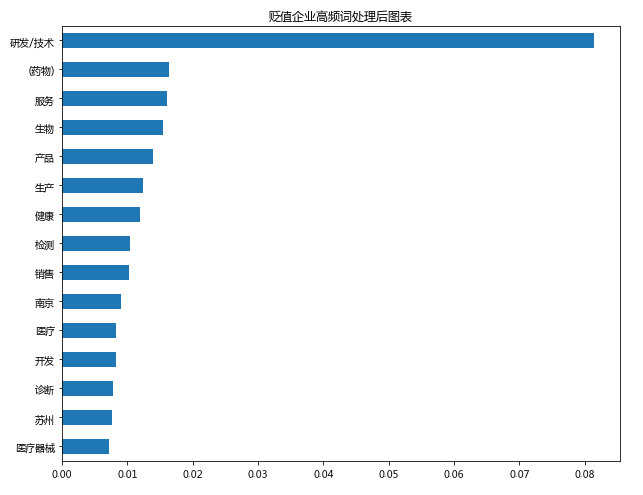

In [ ]:
## 下面是利用分类好的企业，对注册资本、商标数量、著作权数量进行k-s检验
from scipy.stats import ks_2samp

#资本-检验
ziben_test=ks_2samp(medical0['注册资本'],medical1['注册资本'])
print('资本-检验:',ziben_test)
# 商标数量-检验
shangbiao_test=ks_2samp(medical0['商标数量'],medical1['商标数量'])
print('商标数量-检验:',shangbiao_test)
# 著作权数量-检验
zhuzuo_test=ks_2samp(medical0['著作权数量'],medical1['著作权数量'])
print('著作权-检验:',zhuzuo_test)

资本-检验: Ks_2sampResult(statistic=0.21326807769179518, pvalue=2.756350026749995e-09)
商标数量-检验: Ks_2sampResult(statistic=0.1501819299953877, pvalue=8.074521770400608e-05)
著作权-检验: Ks_2sampResult(statistic=0.07138830523240913, pvalue=0.20312060643540034)

In [1]:
##################
# 以下是对投资轮次数量的对比

In [ ]:
# 投资轮次查看
tz1=medical_tz[medical_tz.标的企业全称.isin(medical1.企业名称.values)]
tz0=medical_tz[medical_tz.标的企业全称.isin(medical0.企业名称.values)]
medical_tz.交易轮次.value_counts().plot(kind='barh',figsize=(10,8),title='总轮次数量')

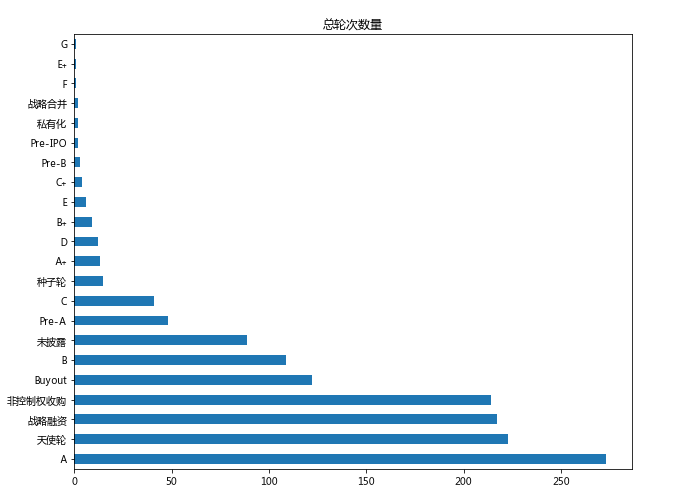

In [ ]:
# 升值企业的
tz1.交易轮次.value_counts().plot(kind='barh',figsize=(10,8),title='升值企业轮次数量')

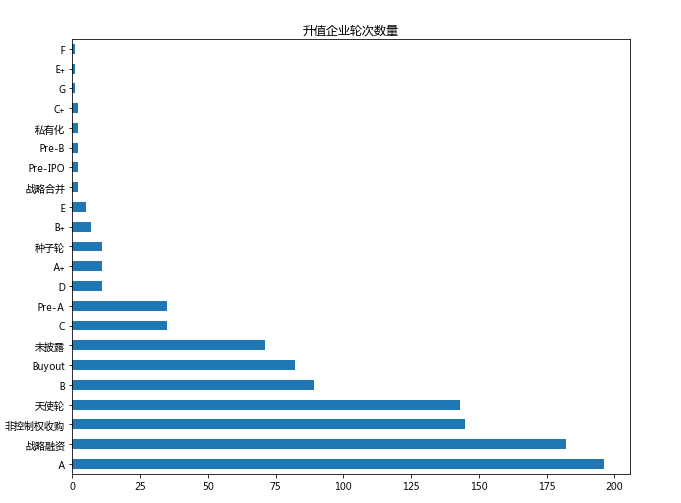

In [ ]:
# 贬值企业的
tz0.交易轮次.value_counts().plot(kind='barh',figsize=(10,8),title='贬值企业轮次数量')

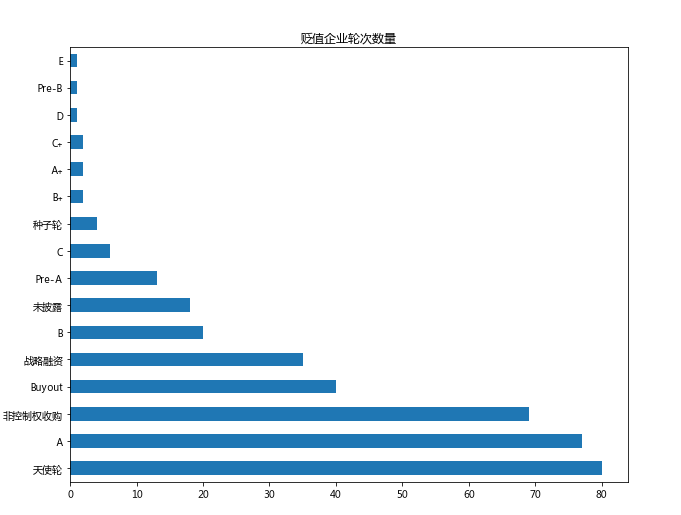

In [2]:
##################
# 以下是各城市投资次数总计对比

In [ ]:
# 升值企业的
tz1.市级.value_counts().plot(kind='barh',title='升值值企业各城市次数分布')

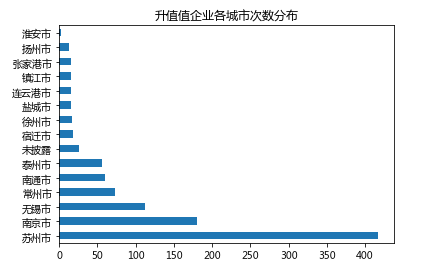

In [ ]:
#贬值企业的
tz0.市级.value_counts().plot(kind='barh',title='贬值企业各城市次数分布')

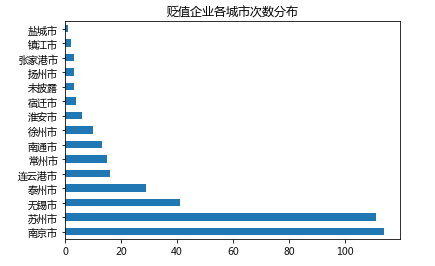

In [3]:
##########################
# 下面是k-s检验的过程和结果
##########################
# 这里的人员数、核心团队人数清洗过程放到文末

In [ ]:
#对medical_jj_nona删除索引
medical_jj_nona=medical_jj_nona.reset_index(drop = True)
# 提取出主要人员数、核心团队人数表格
medical_pernums=pd.read_csv('/home/kesci/work/medical_pernums.csv')
medical_pernums=medical_pernums[['企业名称','主要人员数','核心团队人数']]
# 按照升值、贬值企业分类
exce_pernums=medical_pernums[medical_pernums.企业名称.isin(medical1.企业名称.values)]
bett_pernums=medical_pernums[medical_pernums.企业名称.isin(medical0.企业名称.values)]
# 检验主要人员数与核心团队人数分布是否一致
from scipy.stats import ks_2samp
t1=ks_2samp(exce_pernums['核心团队人数'], bett_pernums['核心团队人数'])
t2=ks_2samp(exce_pernums['主要人员数'], bett_pernums['主要人员数'])
print('主要人员数-检验',t1)
print('核心团队人数数-检验',t2)
# 结果：p值很小，拒绝原假设，分布不一致十分显著

主要人员数-检验 Ks_2sampResult(statistic=0.2352894609764014, pvalue=3.5863325758644213e-11)
核心团队人数数-检验 Ks_2sampResult(statistic=0.28847539205674433, pvalue=1.4035491226358207e-16)

In [ ]:
## 下面是利用分类好的企业，对注册资本、商标数量、著作权数量进行k-s检验
from scipy.stats import ks_2samp

#资本-检验
ziben_test=ks_2samp(medical0['注册资本'],medical1['注册资本'])
print('资本-检验:',ziben_test)
# 商标数量-检验
shangbiao_test=ks_2samp(medical0['商标数量'],medical1['商标数量'])
print('商标数量-检验:',shangbiao_test)
# 著作权数量-检验
zhuzuo_test=ks_2samp(medical0['著作权数量'],medical1['著作权数量'])
print('著作权-检验:',zhuzuo_test)

资本-检验: Ks_2sampResult(statistic=0.21326807769179518, pvalue=2.756350026749995e-09)
商标数量-检验: Ks_2sampResult(statistic=0.1501819299953877, pvalue=8.074521770400608e-05)
著作权-检验: Ks_2sampResult(statistic=0.07138830523240913, pvalue=0.20312060643540034)

In [4]:
########################################
# 下面是对产业描述进行可视化图
# 用来研究说明样的产业更吸引投资


In [ ]:
import jieba
import pandas as pd

medical_tz.业务描述.fillna('暂无',inplace=True)

miaoshu=[]
for strline in medical_tz.业务描述.values:
    for word in cleanline(strline):
        word=word.rstrip('商')
        miaoshu.append(word)
miaoshu 
pd.Series(miaoshu).value_counts()[0:20].plot(kind='barh',figsize=(10,8),title='投资产业描述词频')

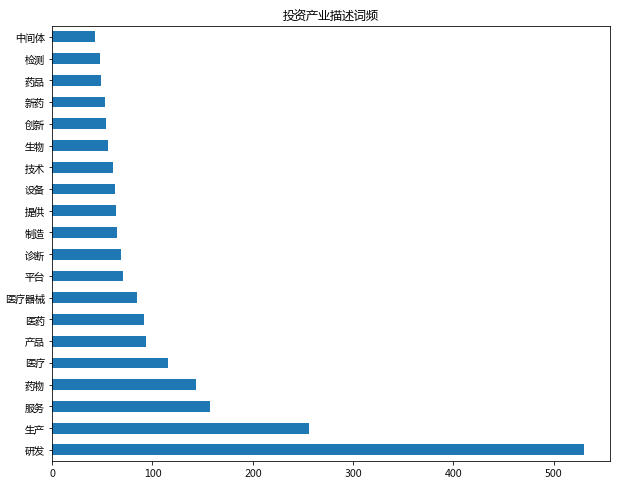

In [ ]:
#对被投资的业务类型求出总投资和，展现出投资最多的前几个
# 用来研究什么样的业务跟吸引投资
tz_sum=medical_tz.groupby(medical_tz.业务描述)['总交易金额 (万元)'].sum()
tz_sum[tz_sum>2e5].plot(kind='barh')

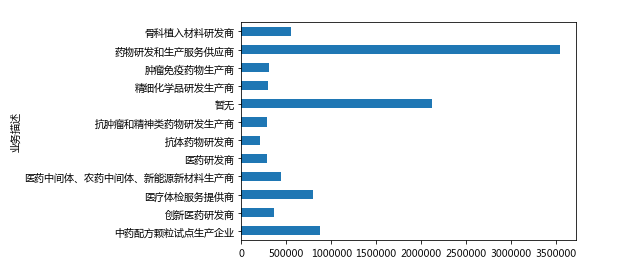

In [5]:
###############################3
# 下面是分析过程中用到的几幅时间趋势图

In [ ]:
# 生物医药每年注册资本量
medical_gs.groupby(medical_gs.index.year).注册资本.sum().plot(title='生物医药每年注册资本量')

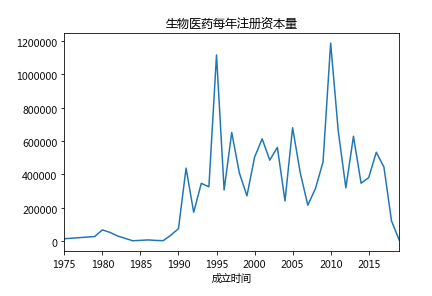

In [ ]:
# 生物医药每年入驻企业数量
medical_gs.groupby(medical_gs.index.year).注册资本.count().plot(title='生物医药每年入驻企业数量')

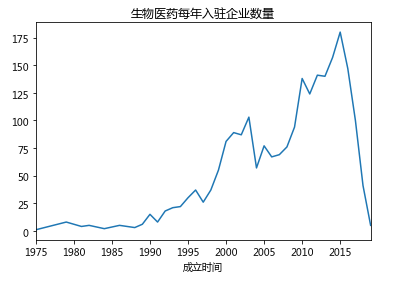

In [ ]:
# 生物医药每年商标数量
medical_gs.groupby(medical_gs.index.year).商标数量.sum().plot(title='生物医药每年商标数量')

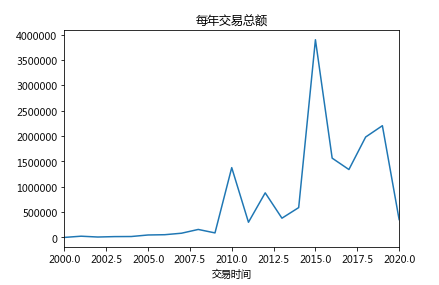

In [ ]:
#每年交易总次数
medical_tz.groupby(medical_tz.index.year)['总交易金额 (万元)'].count().plot(title='每年交易总次数')

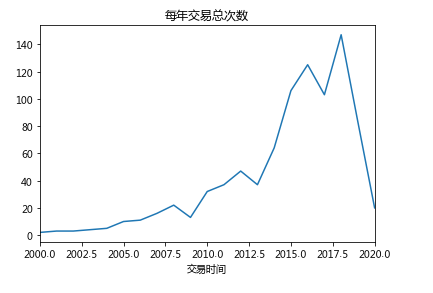

In [6]:
##############################
# 以下是绘制政策颁布数量按年限变化图
##############################

In [ ]:
# 绘制已有城市的数据图像
import pandas as pd 
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
CITY=['苏州', '南京', '无锡', '南通', '连云港', '徐州', '宿迁',  '盐城', '镇江', '扬州']
for city in CITY:
    fp='/home/kesci/work/{}.xlsx'.format(city)
    df=pd.read_excel(fp)
    df.index=pd.DatetimeIndex(df.发布日期)
    df=df[df.index.year>=2000]
    df=df[df.index.year!=2020]
    year_num=df.groupby(df.index.year).发布日期.count()
    plt.plot(year_num.index,year_num,label=city)
plt.title('2000-2019年各个城市医疗政策实行数量')
plt.legend()
plt.show()

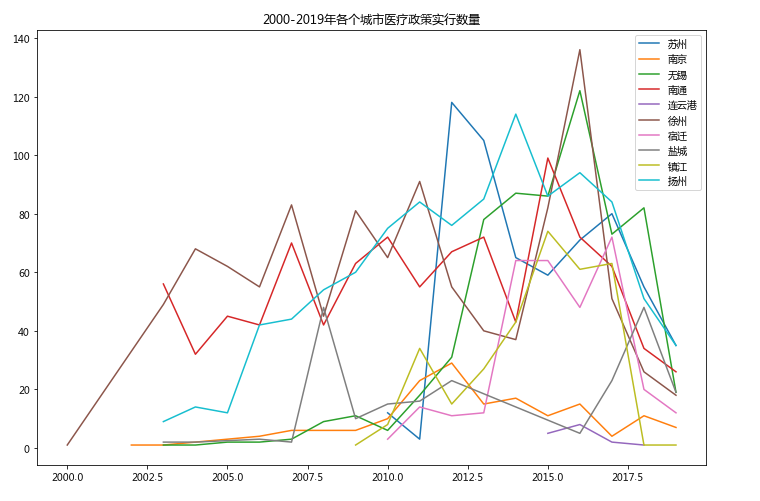

In [ ]:
# 苏州、南京、无锡三大城市对比
plt.figure(figsize=(12,8))
CITY=['苏州', '南京', '无锡']
for city in CITY:
    fp='/home/kesci/work/{}.xlsx'.format(city)
    df=pd.read_excel(fp)
    df.index=pd.DatetimeIndex(df.发布日期)
    df=df[df.index.year>=2000]
    df=df[df.index.year!=2020]
    year_num=df.groupby(df.index.year).发布日期.count()
    plt.plot(year_num.index,year_num,label=city)
plt.title('2000-2019年各个城市医疗政策实行数量（三大城市对比）')
plt.legend()
plt.show()

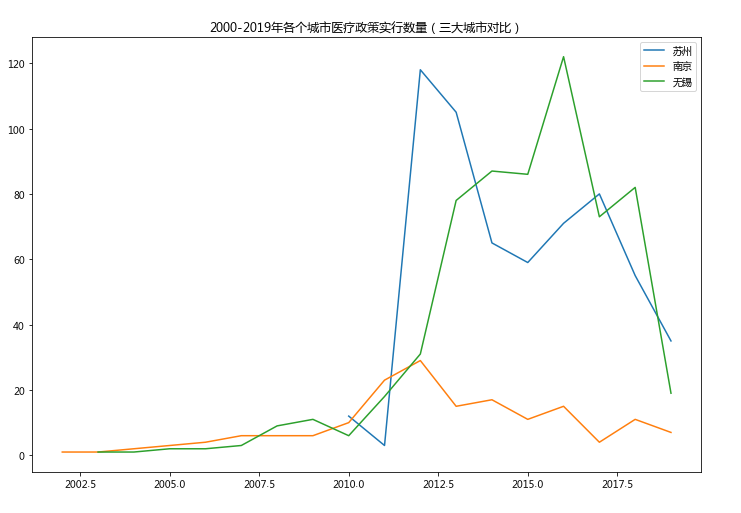

In [ ]:
# 绘制城市被投资次数热图
!pip install --upgrade pip
!pip install pyecharts==0.5.11
!pip install echarts-china-provinces-pypkg
from pyecharts import Map

# 提取城市数据
city_value=medical_tz.市级.value_counts()
city=list(city_value.index)
value=list(city_value)
# 删除未披露
city.pop(7)
value.pop(7)
map2 = Map("江苏地图",'江苏', width=1200, height=600)
map2.add('江苏', city, value, maptype='江苏', is_visualmap=True, visual_text_color='#000')
map2.render_notebook()

In [ ]:
########################
########################
# 下面是对工商信息的人员数、核心团队人数进行计算的代码
# 下面将核心团队、主要人员化为人数（因为名字的信息几乎没有）
person_num=medical_gs[['企业名称','主要人员','核心团队']]
person_num=person_num.fillna(0)

# 数出核心团队、主要人员人数
person_array=np.array(person_num)
person_nums=person_array

for i in range(person_array.shape[0]):
    mps=person_array[i][1]
    try:
        mps=len(mps.split('/'))+1
    except:
        mps=0
    person_nums[i][1]=mps
    
for i in range(person_array.shape[0]):
    mts=person_array[i][2]
    try:
        mts=len(mts.split('/'))+1
    except:
        mts=0
    person_nums[i][2]=mts

medical_pernums=pd.DataFrame(person_nums)
medical_pernums.columns=['企业名称','主要人员数','核心团队人数']
medical_pernums.info()

# 最后保存起来
medical_pernums.to_csv('/home/kesci/work/medical_pernums.csv')

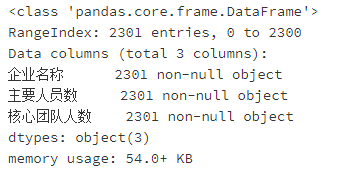